In [ ]:
import lightning as L
from data import FakeNewsDataModule
from model import NLPModel
import torch

import pandas as pd

In [ ]:
from pathlib import Path

xlm_roberta = NLPModel.load_from_checkpoint(Path("fakenews-detection") / "model.ckpt")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", )

In [ ]:
def collate_fn(batch):

    tokenized = tokenizer([x["text"] for x in batch], padding=True)

    return {
        "input_ids": torch.tensor(tokenized["input_ids"]),
        "attention_mask": torch.tensor(tokenized["attention_mask"]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

In [ ]:
vf_ds = VerafilesDataset("vefafiles.csv", transform=None)
vf_dl = torch.utils.data.DataLoader(vf_ds, collate_fn=collate_fn, batch_size=8)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 109/109 [00:21<00:00,  4.98it/s]


/var/folders/qp/m74hqv_10t3ckj5rm579lm3m0000gp/T/ipykernel_28677/4006778802.py:101: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  conf_img = PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.04137931019067764    │
│          test_f1          │    0.05619551241397858    │
│         test_loss         │     9.13490104675293      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 9.13490104675293,
  'test_accuracy': 0.04137931019067764,
  'test_f1': 0.05619551241397858}]

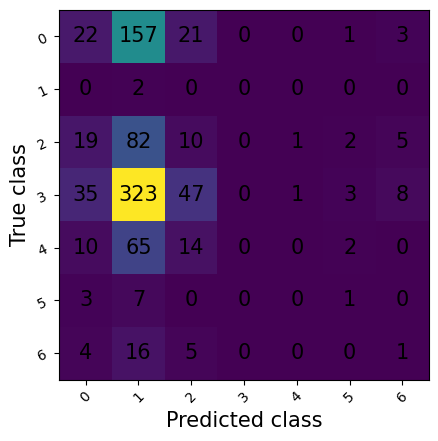

In [ ]:
trainer.test(model=xlm_roberta, dataloaders=[vf_dl])

# Additional Testing

In [ ]:
from pathlib import Path

xlm_roberta = NLPModel.load_from_checkpoint(Path("fakenews-detection") / "model.ckpt")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_model = xlm_roberta.model.roberta

In [ ]:
import torch
import pandas as pd

In [ ]:
class VerafilesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        
        self.root = root
        self.transform = transform
        self.df = pd.read_csv(root)

        self.idx2label = {k:v for k,v in enumerate(self.df["label"].unique())}
        self.label2idx = {v:k for k,v in self.idx2label.items()}

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = row["text"]
        label = self.label2idx[row["label"]]
        return {
            "text": text,
            "label": label
        }

In [ ]:
class XFactDataset(torch.utils.data.Dataset):
    def __init__(self, root, examples=20, transform=None):
        super().__init__()
        
        self.root = root
        self.transform = transform
        self.df = pd.read_csv(root, sep="\t")

        self.idx2label = {k:v for k,v in enumerate(self.df["label"].unique())}
        self.label2idx = {v:k for k,v in self.idx2label.items()}

        self.df = pd.concat([self.df[self.df["label"] == key].head(examples) for key in self.label2idx.keys()], ignore_index=True)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = row["claim"]
        label = self.label2idx[row["label"]]
        return {
            "text": text,
            "label": label
        }

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", )

In [ ]:
tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [ ]:
def collate_fn(batch):

    tokenized = tokenizer([x["text"] for x in batch], padding=True)

    return {
        "input_ids": torch.tensor(tokenized["input_ids"]),
        "attention_mask": torch.tensor(tokenized["attention_mask"]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

In [ ]:
vf_ds = VerafilesDataset("vefafiles.csv", transform=None)
vf_dl = torch.utils.data.DataLoader(vf_ds, collate_fn=collate_fn, batch_size=8)

In [ ]:
xf_ds = XFactDataset("xlm_fakenews/train.tsv")
xf_dl = torch.utils.data.DataLoader(xf_ds, collate_fn=collate_fn, batch_size=8)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [ ]:
writer = SummaryWriter()

In [ ]:
roberta_model = roberta_model.to("mps")

In [ ]:
embeddings = []
labels = []

for batch in vf_dl:

    input_ids = batch["input_ids"].to("mps")
    attention_mask = batch["attention_mask"].to("mps")
    labels_batch = batch["labels"]
    
    labels_batch = ["vf"+vf_ds.idx2label[x.item()] for x in labels_batch] # convert to normal index
    labels.extend(labels_batch)

    # print(type(input_ids))

    with torch.no_grad():
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

In [ ]:
for batch in xf_dl:

    input_ids = batch["input_ids"].to("mps")
    attention_mask = batch["attention_mask"].to("mps")
    labels_batch = batch["labels"]
    
    labels_batch = ["xf"+xf_ds.idx2label[x.item()] for x in labels_batch] # convert to normal index
    labels.extend(labels_batch)

    # print(type(input_ids))

    with torch.no_grad():
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

In [ ]:
embeddings_cat = np.concatenate(embeddings)

In [ ]:
embeddings_cat.shape

(1010, 768)

In [ ]:
writer.add_embedding(embeddings_cat, metadata=labels, tag="vf_and_xf_representation")
writer.close()

In [ ]:
xf_ds.idx2label

{0: 'false',
 1: 'partly true/misleading',
 2: 'true',
 3: 'mostly true',
 4: 'mostly false',
 5: 'complicated/hard to categorise',
 6: 'other'}